In [1]:
#! /usr/bin/python
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy.constants import c, hbar, elementary_charge, Boltzmann
from sklearn import metrics

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.chdir('..')
import utils.utilities as u
import utils.dynamics as d

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from utils.detector_position_regression_params import *

In [3]:

LPYD = LPYD[1:,:]                            # Remove first row 
nz = np.nonzero(LPYD[:,2].astype(float))[0]  # Find rows with non-zero probability
LPYD = LPYD[nz,:]                            # Isolate Rows with non-zero probability

DupYLabels = LPYD[:,1]          # Extract the y labels from LPYD (with duplicates)
ylabels = []                    # Remove the duplicates
for i in DupYLabels: 
    if i not in ylabels: 
        ylabels.append(i)

plist = LPYD[:,2].astype(float) # Extract probabilities from LYPD
ptot  = sum(plist)              # Compute their sum
plist = plist/ptot              # Normalize them
cases = len(plist)              # Number of cases being considered

ylist  = LPYD[:,3]  # Extract y-values from LPYD (with duplicates)    
Blist = LPYD[:,4].astype(int)      # Extract Boudary conditions from LPYD
Dlist = LPYD[:,5].astype(int)      # Extract Distances from LPYD
TempList = LPYD[:,6].astype(float) # Extract Distances from LPYD
SmearList = LPYD[:,7] # Extract Distances from LPYD
DimList = LPYD[:,8] # Extract Distances from LPYD

In [4]:
data_dir = os.getcwd() + "\\Data\\" + experiment_name
try:
    os.mkdir(data_dir)
except FileExistsError:
    pass

In [7]:
# hamiltonian represented by symplectic form F, where F is in basis (q1,..., qN, qD, p1, ..., pN, pD)
Flist_dynamic = [0]*cases         # List of Hamiltonians for dynamics, for each scenario
Flist_thermal = [0]*cases         # List of Hamiltonians for thermality
for k in range(cases):
    Flist_dynamic[k], Flist_thermal[k] = \
        d.get_symplectic_generator(wD,mcc,lam,latlen,sigma,Blist[k],Dlist[k],smearing=SmearList[k],dim=DimList[k])

In [56]:
acc = []
val_acc = []
confusion = []

In [ ]:
for t_index in range(len(plot_times_min)):
    tmax = plot_times_max[t_index]
    tmin = plot_times_min[t_index]
    print('Run', t_index, 'of', len(plot_times_max), 'at time', str(np.round(tmin,5)), 'to time', str(np.round(tmax,5)))

    case_time = experiment_name + '_time_'+str(np.round(tmax,5))
    time_dir = data_dir + '\\' + case_time
    try:
        os.mkdir(time_dir)
    except FileExistsError:
        pass

    expdata_name = case_time + '_exp_and_pca_data'
    expdata_dir = time_dir + '\\' + expdata_name

    expdata_exists = False
    pcadata_exists = False
    try:
        os.mkdir(expdata_dir)
    except FileExistsError:
        expdata_exists = os.path.isfile(expdata_dir+'\\exp_data_all.csv')
        pcadata_exists = os.path.isfile(expdata_dir+'\\pca_data_all.csv')
        accdata_exists = os.path.isfile(expdata_dir+'\\acc_data_all.csv')

    if not expdata_exists or overwrite:
        projector_list, median_projector, \
            state_list_0, median_state_0, \
                prepicked_trajectories, median_trajectory, \
                    BigDSList, reglist = \
            u.get_probe_trajectories(
                Flist_dynamic, 
                Flist_thermal, 
                latlen,
                Blist, 
                TempList, 
                Tdev, 
                tmin,
                tmax,
                t_index,
                measurements_per_window, 
                cases, 
                n_samples,  
                Regression)
        exp_data = u.generate_measurement_data(
            projector_list, 
            median_projector, 
            prepicked_trajectories, 
            median_state_0, 
            BigDSList,
            cases, 
            n_samples, 
            measurements_per_window, 
            n_tom, 
            Tdev,
            ylist,
            Regression, 
            reglist,
            save=True, 
            path=expdata_dir + '\\')
        
        exp_data = np.asarray(exp_data)
    else:
        exp_data = np.asarray(pd.read_csv(expdata_dir+'\\exp_data_all.csv'))

    LO = 1                  # Fraction of variance to be kept after PCA (0 to 1 or 'All') 

    print('Performing PCA')
    if not pcadata_exists or overwrite or not expdata_exists:
        PCAdData = u.run_PCA_on_data(
            exp_data, 
            f_train, 
            PCA_var_keep, 
            cases, 
            save=True, 
            path=expdata_dir + '\\')
    else:
        PCAdData = np.asarray(pd.read_csv(expdata_dir+'\\pca_data_all.csv'))

    print('defining model')
    ### DEFINE THE NETWORK ARCHITECTURE ###
    nI = PCAdData.shape[1]-LO
    nO = 1 if Regression else len(ylabels)
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(nI,)),
        tf.keras.layers.Dense(
            3#, 
            #activation=tf.keras.layers.ReLU()
            #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=np.sqrt(2/(nH1+nO))), 
            #bias_initializer=tf.keras.initializers.Zeros()
        ),
        tf.keras.layers.Dense(
            nO#, 
            #activation=tf.keras.layers.ReLU()
            #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=np.sqrt(2/(nH1+nO))), 
            #bias_initializer=tf.keras.initializers.Zeros()
        )
    ])

    def custom_loss_with_l2_reg(lambda_value):
        def loss(y_true, y_pred):
            eps = 10**(-10) # to prevent the logs from diverging
            if Regression:
                cross_entropy = tf.losses.mean_squared_error(y_true,y_pred)
            else:
                cross_entropy = tf.reduce_mean(tf.reduce_sum( -y_true * tf.log(y_pred+eps), reduction_indices=[1]))
            l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights])
            return cross_entropy + lambda_value*l2_loss
        return loss

    if True:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        loss = custom_loss_with_l2_reg(L2reg)

        print('compiling model')
        model.compile(
            optimizer=optimizer, 
            loss=loss, 
            metrics=['mae'] if Regression else ['accuracy'])

        n_train = int(PCAdData.shape[0]*(f_train+f_valid))
        n_test = PCAdData.shape[0] - n_train
        x_train = PCAdData[:n_train, :-LO]
        x_test = PCAdData[n_train:n_train+n_test, :-LO]
        y_train = PCAdData[:n_train, -LO:]
        y_test = PCAdData[n_train:n_train+n_test, -LO:]

        if not Regression:
            y_train_OH = tf.keras.utils.to_categorical(y_train, num_classes=nO)
            y_test_OH = tf.keras.utils.to_categorical(y_test, num_classes=nO)

        print('training model')

        history = model.fit(
            x_train, 
            y_train, 
            epochs=25, 
            verbose=1, 
            validation_split=f_valid/(f_valid+f_train), 
            batch_size=minibatch_size)

        if Regression:
            accs = [0.5, 0.25, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]
            y_pred = model.predict(x_test)
            accuracy = [np.sum(np.abs(y_test - y_pred) < acc)/y_test.shape[0] for acc in accs]
            print(accuracy)
            val_acc.append(accuracy)
        else:
            val_acc.append(history.history['val_acc'][-1])
            print(history.history['val_acc'][-1])
            y_pred = model.predict(x_test)
            confusion.append(metrics.confusion_matrix(y_test_OH.argmax(axis=1), y_pred.argmax(axis=1), labels=list(range(len(ylabels)))))

In [66]:
if not Regression:
    conf = np.zeros((len(confusion[0].flatten()), len(confusion)))
    for i, c in enumerate(confusion):
        conf[:, i] = confusion[i].flatten()

plot_times_max_arr = np.asarray(plot_times_max).reshape((-1, 1)).T
plot_times_min_arr = np.asarray(plot_times_min).reshape((-1, 1)).T
if not Regression:
    val_acc_arr = np.asarray(val_acc).reshape((-1, 1)).T
else:
    val_acc_arr = np.asarray(val_acc).T

output = (plot_times_min_arr, plot_times_max_arr, val_acc_arr) if Regression else (plot_times_min_arr, plot_times_max_arr, val_acc_arr, conf)
test_result = np.concatenate(output, axis=0)

if not os.path.isfile(data_dir+'\\test_output.csv') or overwrite:
    pd.DataFrame(test_result).to_csv(data_dir+'\\test_output.csv')

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


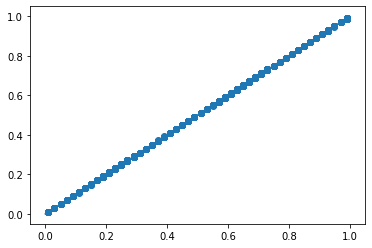

In [ ]:
import matplotlib.pyplot as plt
y_pred = model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.plot([0,1], [0,1])#, model.predict(x_test))
#plt.xlim(0, 1)
#plt.ylim(0, 1)

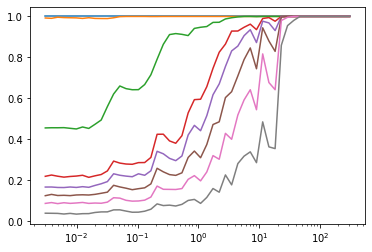

In [68]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots()
for i in range(val_acc_arr.shape[0]):
    ax.plot(plot_times_max, val_acc_arr[i])
    #ax.plot(plot_times_max[-14:-9], np.asarray(val_acc).T[i])
ax.set_xscale('log')

In [85]:
import utils.dynamics as d

d.SquareLatticeAdjList(3,2,True, False, False, True)

[[3], [2, 4], [1, 5], [6, 0], [5, 7, 1], [4, 8, 2], [3], [8, 4], [7, 5]]